In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

In [4]:
X_train_estimated_b['date_forecast'].min()

Timestamp('2022-10-28 22:00:00')

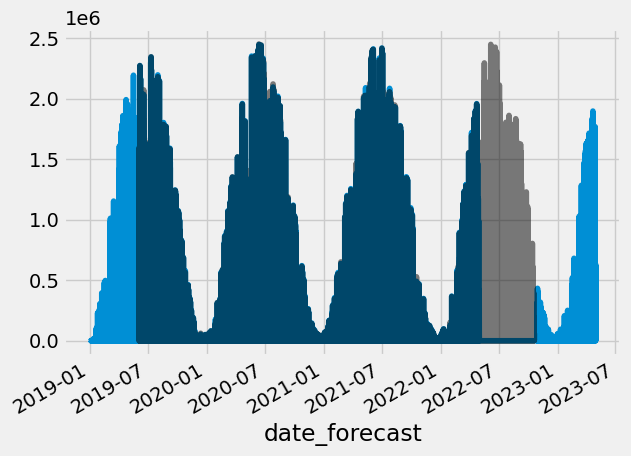

In [5]:
''' 
FEATURES = [
    'direct_rad_1h:J', 'effective_cloud_cover:p', 'clear_sky_energy_1h:J',
    'visibility:m', 'sun_elevation:d', 'is_day:idx','hour', 'dayofweek', 'quarter', 'month', 
    'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'location_A', 'location_B', 'location_C', 
    'estimated'
]

'''

feature = 'direct_rad_1h:J'

x = pd.concat([X_train_observed_c, X_train_estimated_c])
x.set_index('date_forecast', inplace=True)

x[feature].plot()
X_train_observed_a.set_index('date_forecast', inplace= True)
X_train_observed_a[feature].plot(color='black',alpha=0.5)
plt.show()

In [6]:
print(set([type(i) for i in x.index]))
full_date_range = pd.date_range(start=x.index.min(), end=x.index.max(), freq='H')
missing_dates = full_date_range.difference(x.index)
missing_df = pd.DataFrame(index=missing_dates)
x = pd.concat([x, missing_df]).sort_index()

{<class 'pandas._libs.tslibs.timestamps.Timestamp'>}


In [7]:
x.loc['2022-01-01']

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc
2022-01-01 00:00:00,4.5,1.286,NaN,0.0,0.0,134.600006,-1.0,272.100006,0.0,0.0,...,-49.186001,0.0,274.000000,38.200001,36640.898438,1.6,1.3,-1.0,0.0,NaT
2022-01-01 00:15:00,4.4,1.288,NaN,0.0,0.0,276.299988,-1.0,271.799988,0.0,0.0,...,-48.744999,0.0,274.000000,30.400000,38501.300781,1.7,1.5,-0.9,0.0,NaT
2022-01-01 00:30:00,4.3,1.290,NaN,0.0,0.0,418.100006,-1.0,271.500000,0.0,0.0,...,-48.159000,0.0,274.000000,22.299999,40342.699219,1.8,1.7,-0.7,0.0,NaT
2022-01-01 00:45:00,4.1,1.292,NaN,0.0,0.0,559.799988,-1.0,271.200012,0.0,0.0,...,-47.436001,0.0,274.000000,14.000000,42165.300781,1.9,1.8,-0.6,0.0,NaT
2022-01-01 01:00:00,4.0,1.294,NaN,0.0,0.0,701.500000,-1.0,270.799988,0.0,0.0,...,-46.583000,0.0,274.000000,5.500000,43969.398438,2.0,2.0,-0.5,0.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 22:45:00,3.7,1.256,3514.399902,0.0,0.0,1236.300049,0.0,269.600006,0.0,0.0,...,-49.181999,0.0,276.600006,91.500000,59466.898438,3.9,-0.6,3.8,-0.0,NaT
2022-01-01 23:00:00,3.7,1.256,2946.199951,0.0,0.0,1389.000000,0.0,269.700012,0.0,0.0,...,-49.473999,0.0,276.700012,87.900002,59480.398438,4.0,-0.4,3.9,-0.0,NaT
2022-01-01 23:15:00,3.7,1.256,2946.199951,0.0,0.0,1420.099976,0.0,269.700012,0.0,0.0,...,-49.611000,0.0,276.799988,82.699997,58954.898438,4.1,-0.4,4.1,-0.0,NaT
2022-01-01 23:30:00,3.8,1.256,2946.199951,0.0,0.0,1451.099976,0.0,269.799988,0.0,0.0,...,-49.591000,0.0,276.799988,76.599998,58429.601562,4.3,-0.3,4.3,-0.0,NaT


<Axes: xlabel='date_forecast'>

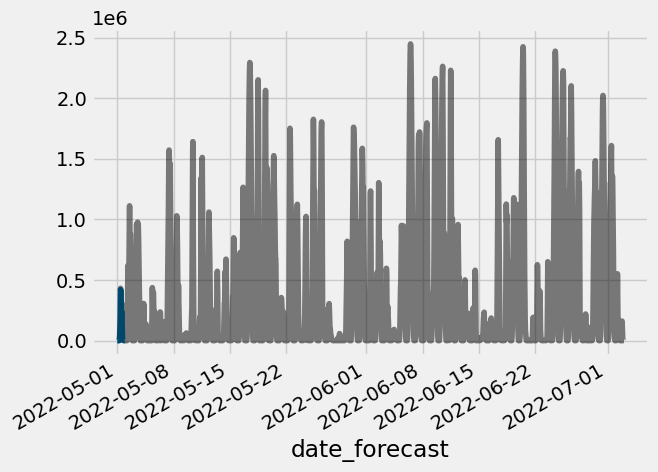

In [8]:
start = '2022-05-01'
end = '2022-07-02'

x[start:end][feature].plot()
X_train_observed_a[start:end][feature].plot(color='black',alpha=0.5)

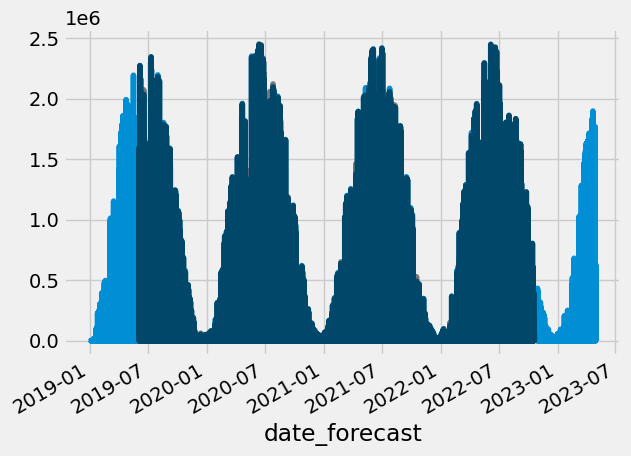

In [9]:
x = x.combine_first(X_train_observed_a)


x[feature].plot()
X_train_observed_a[feature].plot(color='black',alpha=0.5)
plt.show()

<Axes: >

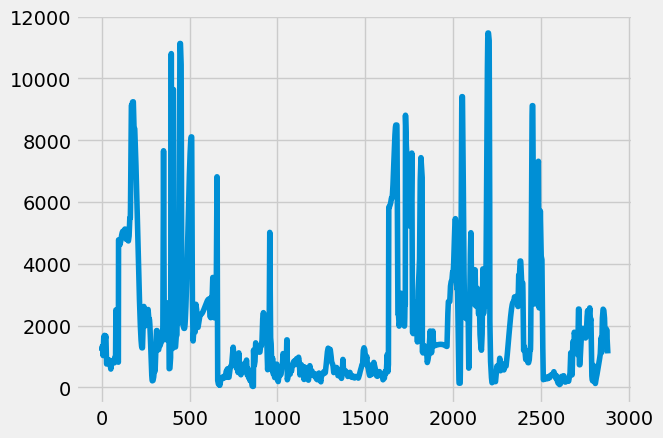

In [10]:
#X_test_estimated_c.set_index('date_forecast', inplace=True)
X_test_estimated_c['cloud_base_agl:m'] = X_test_estimated_c['cloud_base_agl:m'].interpolate(method='polynomial', order=3)
X_test_estimated_c['cloud_base_agl:m'].plot()

In [11]:
X_test_estimated_c.isna().sum()

date_calc                            0
date_forecast                        0
absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m               849
clear_sky_energy_1h:J                0
clear_sky_rad:W                      0
cloud_base_agl:m                     0
dew_or_rime:idx                      0
dew_point_2m:K                       0
diffuse_rad:W                        0
diffuse_rad_1h:J                     0
direct_rad:W                         0
direct_rad_1h:J                      0
effective_cloud_cover:p              0
elevation:m                          0
fresh_snow_12h:cm                    0
fresh_snow_1h:cm                     0
fresh_snow_24h:cm                    0
fresh_snow_3h:cm                     0
fresh_snow_6h:cm                     0
is_day:idx                           0
is_in_shadow:idx                     0
msl_pressure:hPa                     0
precip_5min:mm                       0
precip_type_5min:idx     

,time,pv_measurement
0,2018-12-31 23:00:00,0.0000
1,2019-01-01 00:00:00,0.0000
2,2019-01-01 01:00:00,0.0000
3,2019-01-01 02:00:00,0.0000
4,2019-01-01 03:00:00,0.0000
5,2019-01-01 04:00:00,0.0000
6,2019-01-01 05:00:00,0.0000
7,2019-01-01 06:00:00,0.0000
8,2019-01-01 07:00:00,0.0000
9,2019-01-01 08:00:00,0.0000


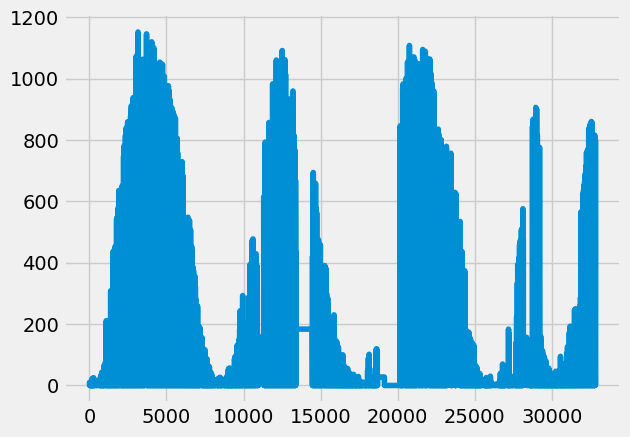

In [12]:
#train_b.set_index('time', inplace=True)
train_b['pv_measurement'].plot()
train_b.head(40)

In [13]:
r = 2880 * 3
predictions = [i for i in range(r)]

predictions = pd.DataFrame(predictions, columns=['prediction'])
#predictions['time'] = X_test.index
#predictions.set_index('time', inplace=True)
#predictions['prediction'] = scaler_a.inverse_transform(predictions[['prediction']])

n = len(predictions)

# Set value for the top third rows
predictions.loc[:n//3, 'prediction'] = -69

# Set value for the middle third rows
predictions.loc[n//3:2*n//3, 'prediction'] = 42

# Set value for the bottom third rows
predictions.loc[2*n//3:, 'prediction'] = 99



predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

In [14]:
X_test_estimated_a.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,...,10.520000,-11.185,0.0,273.799988,80.699997,30210.699219,4.0,2.2,3.4,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,...,14.203000,-10.825,0.0,273.799988,77.000000,30003.599609,4.0,2.1,3.4,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.3,1.287,912.700012,0.0,0.0,1068.300049,0.0,271.600006,...,17.868999,-10.360,0.0,273.799988,73.099998,29797.099609,3.9,2.1,3.3,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.3,1.287,912.700012,0.0,0.0,1081.900024,0.0,271.600006,...,21.514000,-9.794,0.0,273.799988,69.000000,29618.599609,3.9,2.0,3.3,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.3,1.287,NaN,0.0,0.0,1095.400024,0.0,271.600006,...,25.135000,-9.128,0.0,273.799988,64.500000,29507.500000,3.9,2.0,3.3,-0.0


In [15]:
X_test_estimated_b.shape

(2880, 47)

In [16]:
X_test_estimated_c.shape

(2880, 47)

In [17]:
X_train_observed_a = X_train_observed_a.loc['2021-01-03':]
X_train_observed_a.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
date_forecast,,,,,,,,,,,,,,,,,,,,,
2021-01-03 00:00:00,3.0,1.333,NaN,0.0,0.0,NaN,0.0,267.000000,0.0,0.0,...,11.829000,-48.995998,0.0,269.000000,0.0,42545.699219,1.3,-0.2,1.3,-0.0
2021-01-03 00:15:00,2.9,1.334,NaN,0.0,0.0,159.0,0.0,266.899994,0.0,0.0,...,17.052000,-48.577000,0.0,268.799988,3.4,43022.398438,1.3,-0.1,1.3,-0.0
2021-01-03 00:30:00,2.9,1.335,NaN,0.0,0.0,159.0,0.0,266.700012,0.0,0.0,...,22.193001,-48.012001,0.0,268.600006,6.8,43499.699219,1.3,-0.0,1.3,-0.0
2021-01-03 00:45:00,2.9,1.335,NaN,0.0,0.0,159.0,0.0,266.600006,0.0,0.0,...,27.233000,-47.308998,0.0,268.399994,10.2,43977.601562,1.3,0.0,1.3,-0.0
2021-01-03 01:00:00,2.8,1.336,NaN,0.0,0.0,159.0,0.0,266.399994,0.0,0.0,...,32.157001,-46.476002,0.0,268.299988,13.6,44456.101562,1.3,0.1,1.3,-0.0


In [21]:
(X_test_estimated_a.shape[0] / 4) * 3

2160.0

In [22]:
X_test_estimated_a.shape[0] / 4

720.0